# COMP90051 Project 2

In [23]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## 1. Implementing ε-Greedy and UCB

In [24]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [25]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        self.narms = narms
        self.epsilon = epsilon
        #initialization the value of Q0 to infinity and creating a list Qstore
        
        self.Qstore = [0]*narms
        for every in range(narms):
            self.Qstore[every] += Q0
        #For every number of arms creating a list of arm rewards
        self.arm_rewards = [[] for every in range(narms)]
        self.rewards = []
        
    def play(self, tround, context=None):
        
        #selecting random numbers  between 0 to 1
        #applying  explore or exploit condition
        if np.random.random() > self.epsilon: # exploit
            max_qvalue = max(self.Qstore)
            arm = [every + 1 for every in range(len(self.Qstore)) if self.Qstore[every] == max_qvalue]
            arm=np.random.choice(arm) # in case of tie braek, randomly select largest value
        else:  # explore
            attribute1 = 1
            attribute2 = self.narms + 1
            arm = np.random.randint(attribute1, attribute2)
        return arm
        
    def update(self, arm, reward, context=None):
        self.rewards = [*self.rewards,reward] # computing reward for arms
        self.arm_rewards[arm - 1].append(reward)
        self.Qstore[arm - 1] = np.mean(self.arm_rewards[arm - 1])
        

In [26]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        self.narms = narms
        self.rho = rho
        self.Q0 = Q0
        #intialization the value of Q0 to infinity and creating a list Qstore
        self.Qstore = [0]*narms
        for every in range(narms):
            self.Qstore[every] += Q0
        #creating a list of arm rewards for number of arms
        self.arm_rewards = [[] for every in range(narms)]
        self.rewards = []
    
    def play(self, tround, context=None):
        for every in range(0, self.narms):
            if self.Qstore[every] != self.Q0:
                #apply formula of UCB
                var = self.arm_rewards[every]
                var_1 = np.log(tround)
                var_2 = len(var)
                self.Qstore[every] = np.mean(var) + (self.rho * var_1 / var_2) ** 0.5
        # computing maximum of Qs
        max_qvalue = max(self.Qstore)
        arm = [every + 1 for every in range(0, self.narms) if self.Qstore[every] == max_qvalue]
        arm=np.random.choice(arm)  # in case of tie braek, randomly select largest value
        return arm
        
    def update(self, arm, reward, context=None):
        self.rewards = [*self.rewards,reward] # computing reward for arms
        self.arm_rewards[arm - 1].append(reward)
        self.Qstore[arm - 1] = np.mean(self.arm_rewards[arm - 1])
        

## 2. The Basic Thompson Bandit

In [27]:
class BetaThompson(MAB):
    """
    Beta-Bernoulli Thompson sampling multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    alpha0 : float, optional
        positive real prior hyperparameter

    beta0 : float, optional
        positive real prior hyperparameter
    """
    
    def __init__(self, narms, alpha0=1.0, beta0=1.0):
        self.narms = narms
        self.alpha0 = alpha0
        self.beta0 = beta0
        # initialization s as list of alpha0 and f as list of beta0
        self.s= []         
        for every in range(narms):
            self.s.append(alpha0)
        self.f = [beta0] * narms
        self.rewards = []
    
    def play(self, tround, context=None):
        """
        creating a b_list of zero for number of arms
        and computing sample of beta distribution using list of s and f
        
        """
        
        b_list=[np.random.beta(self.s[every], self.f[every]) for every in range(self.narms)]
        max_beta = max(b_list) #calculate maximum of beta
        arm=[every + 1 for every in range(len(b_list)) if b_list[every]==max_beta]
        arm=np.random.choice(arm)  # in case of tie braek, randomly select largest value
        return arm
        
    def update(self, arm, reward, context=None):
        #compute reward for narms and if reward is zero then increment f by one else increment s by one
        self.rewards = [*self.rewards,reward] 
        num = 1
        if reward != num:
            self.f[arm - 1] += num
        else:
            self.s[arm-1] += num

## 3. Off-Policy Evaluation

In [28]:
dataset = np.loadtxt('dataset.txt') #intializing tha dataset given for project2

# changing the value of arms to integer
arms = dataset[:,0].astype(int)
rewards = dataset[:,1]
contexts = dataset[:,2:102]

def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    arms_index = 0
    # initialization the total number of lines that is available in the data set 
    dataset_row = 10000
    for every in range(nrounds):
        while arms_index < dataset_row:
            con = contexts[arms_index]
            if arms[arms_index] != mab.play(every,con):
                arms_index= arms_index + 1
                continue
            else:
                mab.update(arms[arms_index],int(rewards[arms_index]),con)
                arms_index = arms_index + 1
                break
        if arms_index>=len(arms):
            break
    return mab.rewards

In [29]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.27


In [35]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.18125


In [31]:
mab = BetaThompson(10, 1.0, 1.0)
results_BetaThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('BetaThompson average reward', np.mean(results_BetaThompson))

BetaThompson average reward 0.2275


## 4. Contextual Bandits - LinUCB

In [36]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        self.narms = narms
        self.ndims = ndims
        self.alpha = alpha
        self.A = [np.identity(ndims) for every in range(narms)] #initialization the identity matrix of size of dimension of arms context
        #intiliaziting zero matrix and reshaping into size of(ndims,1) 
        self.B = [0]*narms
        for every in range(narms):
            self.B[every] = np.zeros(ndims).reshape((self.ndims,1))
        self.rewards = []
        
    def play(self, tround, context):
        store_list = []
        for every in range(self.narms):
            value_x = np.array(context[every*self.ndims:(every+1)*self.ndims])
            # applying linear UCB algorithm
            # transposing matrix x 
            x_transpose = value_x.T
            #inversing matrix A
            inverse_matrixA = inv(self.A[every])
            #calculating theta
            theta = inverse_matrixA@self.B[every]
            #transposing theta
            theta_transpose = theta.T
            store_list.append(theta_transpose@value_x + self.alpha * ((x_transpose @ inverse_matrixA) @ value_x)**0.5)
        maximum_val = max(store_list) #calculate maximum value
        arm=[every + 1 for every in range(0,self.narms) if store_list[every]==maximum_val]
         # in case of tie braek, randomly select largest value  
        return np.random.choice(arm)
    
    def update(self, arm, reward, context):
        # computing reward for arms
        self.rewards = [*self.rewards,reward]
        reshape = context[(arm-1)*self.ndims:arm*self.ndims]
        value_x = reshape.reshape((self.ndims,1))
        x_transpose = value_x.T
        #updating A and B according to algorithm
        self.A[arm-1] = self.A[arm-1] + np.matmul(value_x,x_transpose)
        self.B[arm - 1] = self.B[arm - 1] + (reward * value_x)
    

In [37]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


## 5. Contextual Bandits - LinThompson

In [38]:
class LinThompson(MAB):
    """
    Contextual Thompson sampled multi-armed bandit (LinThompson)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    v : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, v):
        self.narms = narms
        self.ndims = ndims
        self.v = v
        #initializing B as identity matrix of size of ndims
        self.B =np.identity(ndims)
         #intializing f as zero matrix of size of ndims
        self.f = np.zeros(ndims)
        self.rewards=[]
        
    def play(self, tround, context):
         
        #inverse matrix B using inv
        inverse_matrixB = inv(self.B)
        #applying Linear Thompson algorithm
        multiply = np.random.multivariate_normal((inverse_matrixB @ self.f), self.v * inverse_matrixB)
        score_value = np.matmul(context.reshape(self.narms,self.ndims),multiply)
        maximum_val = max(score_value) # calculate maximum value
        arm=[ every + 1 for every in range(len(score_value)) if score_value[every]==maximum_val]
        # in case of tie braek, randomly select largest value 
        return np.random.choice(arm)
    
    def update(self, arm, reward, context):
        # computing reward for arms
        self.rewards = [*self.rewards,reward]
        #updating f and B according to algorithm
        self.f += reward * context.reshape(self.narms,self.ndims)[arm-1]
        self.B+=np.matmul(context.reshape(self.narms,self.ndims)[arm-1],context.reshape(self.narms,self.ndims)[arm-1].T)
    

In [40]:
mab = LinThompson(10, 10, 1.0)
results_LinThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinThompson average reward', np.mean(results_LinThompson))

LinThompson average reward 0.3625


## 6. Evaluation
### 6.A.

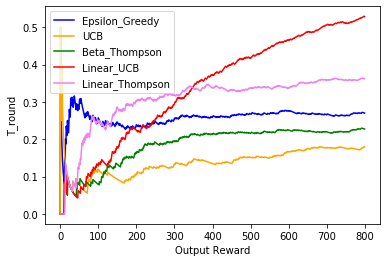

In [41]:
# generating a function to save list of results to plot the graph
def assign(results):
    value = 0
    reward = []
    for each in range(0,len(results)):
        increment = each+1
        division = value/(increment)
        value = value + results[each]
        reward = [*reward,division]
    return reward
# calculating the mean reward of each algorithm
line_EpsGreedy = assign(results_EpsGreedy)
#created a graph to plot all the points
plt.plot(line_EpsGreedy,label = 'Epsilon_Greedy', color = "blue" )
line_UCB = assign(results_UCB)
plt.plot(line_UCB,label = 'UCB', color = "orange")
line_BetaThompson = assign(results_BetaThompson)
plt.plot(line_BetaThompson,label = 'Beta_Thompson', color = "green")
line_LinUCB = assign(results_LinUCB)
plt.plot(line_LinUCB,label = 'Linear_UCB', color = "red")
line_LinThompson = assign(results_LinThompson)
plt.plot(line_LinThompson,label = 'Linear_Thompson', color = "violet")
plt.xlabel("Output Reward")
plt.ylabel("T_round")
plt.legend()
plt.show()

### 6.B.

In [42]:
# compute best alpha and mean result for LinUCB
alpha = np.arange(0,20,0.2)
mean_reward=0
for every in alpha:
    results_LinUCB = offlineEvaluate(LinUCB(10, 10, every), arms, rewards, contexts, 800)
    if np.mean(results_LinUCB)>mean_reward:
        mean_reward= np.mean(results_LinUCB)
        best_alpha = every
print('Linear_UCB best alpha:',best_alpha)
print('Linear_UCB best rewards:',mean_reward)

# compute best v and mean result for LinThompson
best_reward=0
v = np.arange(0,20,0.2)
for every in v:
    results_LinThompson = offlineEvaluate(LinThompson(10, 10, every), arms, rewards, contexts, 800)
    if np.mean(results_LinThompson)>best_reward:
        best_reward= np.mean(results_LinThompson)
        best_v = every
print('Linear_Thompson best v:',round(best_v,4))
print('Linear_Thompson best rewards::',best_reward)

Linear_UCB best alpha: 0.2
Linear_UCB best rewards: 0.6775
Linear_Thompson best v: 15.2
Linear_Thompson best rewards:: 0.3625
